<a href="https://colab.research.google.com/github/FranciscoAguiar/DataScienceProgramming/blob/master/Classificadores2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_predict, TimeSeriesSplit, cross_val_score,cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix,r2_score, accuracy_score, precision_score, recall_score, f1_score,cohen_kappa_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
import time
import warnings
from collections import Counter
from imblearn.over_sampling import ADASYN
warnings.filterwarnings("ignore", category=DeprecationWarning)
import shap
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

In [2]:
!pip install shap

     |████████████████████████████████| 564 kB 2.6 MB/s 


# Data Acquisition

In [49]:
dataset = pd.read_csv('combined.csv', sep=',')
datasetLi = pd.read_csv('combinedLIWC.csv', sep=',')
datasetCo = pd.read_csv('combined_CohMetrix.csv', sep=',')

In [50]:
dataset["classe"].value_counts()

1    890
0    110
Name: classe, dtype: int64

# Desbalanceamento

Class 0: 110
Class 1: 890
Proportion: 0.12 : 1


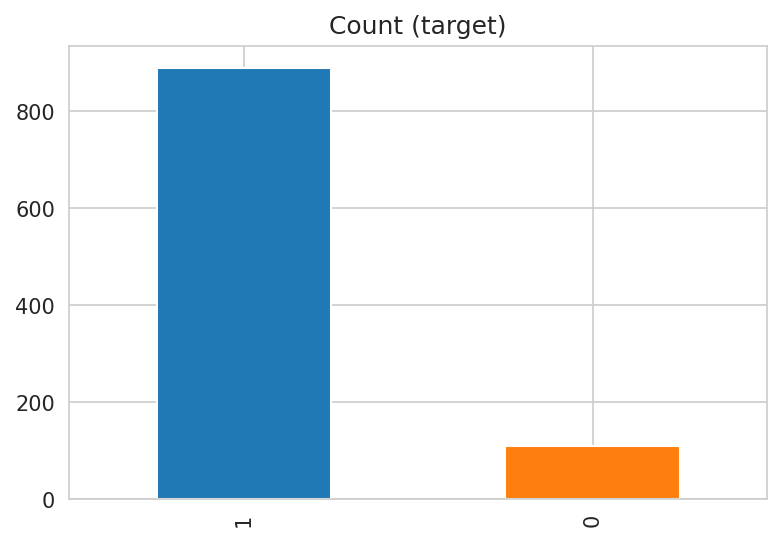

In [51]:
target_count = dataset.classe.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
target_count.plot(kind='bar', title='Count (target)',color = ['#1F77B4', '#FF7F0E']);

# Data Exploration

In [52]:
datasetCo['classe'] = dataset['classe']
datasetCo.head()

,ID,cm.DESPC,cm.DESSC,cm.DESWC,cm.DESPL,cm.DESPLd,cm.DESSL,cm.DESSLd,cm.DESWLsy,cm.DESWLsyd,cm.DESWLlt,cm.DESWLltd,cm.CRFNO1,cm.CRFAO1,cm.CRFSO1,cm.CRFNOa,cm.CRFAOa,cm.CRFSOa,cm.CRFCWO1,cm.CRFCWO1d,cm.CRFCWOa,cm.CRFCWOad,cm.CRFANP1,cm.CRFANPa,cm.LSASS1,cm.LSASS1d,cm.LSASSp,cm.LSASSpd,cm.LSAPP1,cm.LSAPP1d,cm.LSAGN,cm.LSAGNd,cm.LDTTRc,cm.LDTTRa,cm.LDMTLDa,cm.LDVOCDa,cm.CNCAll,cm.CNCCaus,cm.CNCLogic,cm.CNCADC,cm.CNCTemp,cm.CNCAdd,cm.CNCPos,cm.CNCNeg,cm.CNCAlter,cm.CNCConclu,cm.CNCExpli,cm.CNCConce,cm.CNCCondi,cm.CNCConfor,cm.CNCFinal,cm.CNCProp,cm.CNCComp,cm.CNCConse,cm.CNCInte,cm.SMCAUSv,cm.SMCAUSvp,cm.SMCAUSr,cm.SMCAUSlsa,cm.SMCAUSwn,cm.SYNLE,cm.SYNMEDpos,cm.SYNMEDwrd,cm.SYNMEDlem,cm.SYNSTRUTa,cm.SYNSTRUTt,cm.DRNP,cm.DRVP,cm.DRAP,cm.DRPP,cm.DRPVAL,cm.DRNEG,cm.DRGERUND,cm.DRINF,cm.WRDNOUN,cm.WRDVERB,cm.WRDADJ,cm.WRDADV,cm.WRDPRO,cm.WRDPRP1s,cm.WRDPRP1p,cm.WRDPRP2,cm.WRDPRP3s,cm.WRDPRP3p,cm.WRDFRQc,cm.WRDFRQa,cm.WRDFRQmc,cm.WRDAOAc,cm.WRDFAMc,cm.WRDCNCc,cm.WRDIMGc,cm.WRDMEAc,cm.RDFRE,cm.RDFKGL,cm.RDL2,classe
0,23,1,1,18,1.0,0.0,17.0,0.000000,1.888889,0.900254,5.117647,2.193100,0,0,0,0,0,0,NaN,NaN,0.000000,0.000000,0,0,0.000000,0.0,NaN,NaN,0,0,1.000000,0.000000,0.900000,0.882353,40.46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,2,5,2,2,1,0,0,0,0,0,0,6.132208,1.813555,6.132208,464.666667,559.000000,356.142857,339.285714,336.250000,25.356471,13.945882,NaN,0
1,24,1,2,24,2.0,0.0,10.5,0.500000,1.916667,1.100066,5.095238,2.670915,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,0,0.393322,0.0,0.393322,0.000000,0,0,0.696661,0.303339,0.923077,0.952381,123.48,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.674710,6.0,0.50,0.833333,0.916667,0.916667,0.000000,0.000000,0,2,0,0,0,0,0,5,3,7,0,3,0,0,0,0,0,0,6.640197,1.893142,6.308187,375.000000,588.666667,303.000000,323.444444,346.000000,27.485000,11.910000,95.041286,0
2,35,1,2,31,2.0,0.0,12.5,0.500000,1.741935,0.964978,5.040000,2.424541,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,0,0.135975,0.0,0.135975,0.000000,0,0,0.567988,0.432012,1.000000,0.960000,175.00,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.766387,5.0,0.25,0.944444,1.000000,1.000000,0.000000,0.000000,1,3,0,0,0,0,0,4,5,6,2,3,0,0,0,0,0,0,6.633897,1.892192,6.357485,403.000000,590.090909,312.333333,339.818182,375.000000,32.505000,11.706667,96.135954,0
3,37,1,1,7,1.0,0.0,6.0,0.000000,1.857143,1.069045,4.833333,2.266912,0,0,0,0,0,0,NaN,NaN,0.000000,0.000000,0,0,0.000000,0.0,NaN,NaN,0,0,1.000000,0.000000,1.000000,1.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.0,1.00,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,6.600221,1.887103,6.600221,269.000000,561.000000,422.500000,413.500000,349.500000,31.545000,10.350000,NaN,0
4,68,1,4,32,4.0,0.0,6.5,3.640055,1.937500,1.268413,5.500000,3.388328,0,0,0,0,0,0,0.020833,0.029463,0.019189,0.027286,0,0,0.000000,0.0,0.023908,0.053461,0,0,0.142931,0.327327,1.000000,0.920000,87.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.122583,2.0,1.25,1.000000,1.000000,1.000000,0.855264,0.855264,1,2,0,0,0,0,0,1,8,5,1,0,0,0,0,0,0,0,6.422688,1.859837,5.138150,486.000000,599.444444,245.375000,264.666667,293.571429,17.755250,12.335500,122.581573,1


In [53]:
datasetCo.drop(columns=['ID'],inplace=True)
datasetCo.head()

,cm.DESPC,cm.DESSC,cm.DESWC,cm.DESPL,cm.DESPLd,cm.DESSL,cm.DESSLd,cm.DESWLsy,cm.DESWLsyd,cm.DESWLlt,cm.DESWLltd,cm.CRFNO1,cm.CRFAO1,cm.CRFSO1,cm.CRFNOa,cm.CRFAOa,cm.CRFSOa,cm.CRFCWO1,cm.CRFCWO1d,cm.CRFCWOa,cm.CRFCWOad,cm.CRFANP1,cm.CRFANPa,cm.LSASS1,cm.LSASS1d,cm.LSASSp,cm.LSASSpd,cm.LSAPP1,cm.LSAPP1d,cm.LSAGN,cm.LSAGNd,cm.LDTTRc,cm.LDTTRa,cm.LDMTLDa,cm.LDVOCDa,cm.CNCAll,cm.CNCCaus,cm.CNCLogic,cm.CNCADC,cm.CNCTemp,cm.CNCAdd,cm.CNCPos,cm.CNCNeg,cm.CNCAlter,cm.CNCConclu,cm.CNCExpli,cm.CNCConce,cm.CNCCondi,cm.CNCConfor,cm.CNCFinal,cm.CNCProp,cm.CNCComp,cm.CNCConse,cm.CNCInte,cm.SMCAUSv,cm.SMCAUSvp,cm.SMCAUSr,cm.SMCAUSlsa,cm.SMCAUSwn,cm.SYNLE,cm.SYNMEDpos,cm.SYNMEDwrd,cm.SYNMEDlem,cm.SYNSTRUTa,cm.SYNSTRUTt,cm.DRNP,cm.DRVP,cm.DRAP,cm.DRPP,cm.DRPVAL,cm.DRNEG,cm.DRGERUND,cm.DRINF,cm.WRDNOUN,cm.WRDVERB,cm.WRDADJ,cm.WRDADV,cm.WRDPRO,cm.WRDPRP1s,cm.WRDPRP1p,cm.WRDPRP2,cm.WRDPRP3s,cm.WRDPRP3p,cm.WRDFRQc,cm.WRDFRQa,cm.WRDFRQmc,cm.WRDAOAc,cm.WRDFAMc,cm.WRDCNCc,cm.WRDIMGc,cm.WRDMEAc,cm.RDFRE,cm.RDFKGL,cm.RDL2,classe
0,1,1,18,1.0,0.0,17.0,0.000000,1.888889,0.900254,5.117647,2.193100,0,0,0,0,0,0,NaN,NaN,0.000000,0.000000,0,0,0.000000,0.0,NaN,NaN,0,0,1.000000,0.000000,0.900000,0.882353,40.46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,2,5,2,2,1,0,0,0,0,0,0,6.132208,1.813555,6.132208,464.666667,559.000000,356.142857,339.285714,336.250000,25.356471,13.945882,NaN,0
1,1,2,24,2.0,0.0,10.5,0.500000,1.916667,1.100066,5.095238,2.670915,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,0,0.393322,0.0,0.393322,0.000000,0,0,0.696661,0.303339,0.923077,0.952381,123.48,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.674710,6.0,0.50,0.833333,0.916667,0.916667,0.000000,0.000000,0,2,0,0,0,0,0,5,3,7,0,3,0,0,0,0,0,0,6.640197,1.893142,6.308187,375.000000,588.666667,303.000000,323.444444,346.000000,27.485000,11.910000,95.041286,0
2,1,2,31,2.0,0.0,12.5,0.500000,1.741935,0.964978,5.040000,2.424541,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,0,0.135975,0.0,0.135975,0.000000,0,0,0.567988,0.432012,1.000000,0.960000,175.00,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.766387,5.0,0.25,0.944444,1.000000,1.000000,0.000000,0.000000,1,3,0,0,0,0,0,4,5,6,2,3,0,0,0,0,0,0,6.633897,1.892192,6.357485,403.000000,590.090909,312.333333,339.818182,375.000000,32.505000,11.706667,96.135954,0
3,1,1,7,1.0,0.0,6.0,0.000000,1.857143,1.069045,4.833333,2.266912,0,0,0,0,0,0,NaN,NaN,0.000000,0.000000,0,0,0.000000,0.0,NaN,NaN,0,0,1.000000,0.000000,1.000000,1.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.0,1.00,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,6.600221,1.887103,6.600221,269.000000,561.000000,422.500000,413.500000,349.500000,31.545000,10.350000,NaN,0
4,1,4,32,4.0,0.0,6.5,3.640055,1.937500,1.268413,5.500000,3.388328,0,0,0,0,0,0,0.020833,0.029463,0.019189,0.027286,0,0,0.000000,0.0,0.023908,0.053461,0,0,0.142931,0.327327,1.000000,0.920000,87.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.122583,2.0,1.25,1.000000,1.000000,1.000000,0.855264,0.855264,1,2,0,0,0,0,0,1,8,5,1,0,0,0,0,0,0,0,6.422688,1.859837,5.138150,486.000000,599.444444,245.375000,264.666667,293.571429,17.755250,12.335500,122.581573,1


In [54]:
datasetCurrent = datasetCo

In [9]:
pd.options.display.max_columns = None

In [10]:
datasetCurrent.isna().sum(axis=0)

cm.DESPC        0
cm.DESSC        0
cm.DESWC        0
cm.DESPL        0
cm.DESPLd       0
             ... 
cm.WRDMEAc      0
cm.RDFRE        0
cm.RDFKGL       0
cm.RDL2       165
classe          0
Length: 95, dtype: int64

In [11]:
datasetCurrent.isnull().sum(axis = 1)

0      5
1      0
2      0
3      5
4      0
      ..
995    0
996    0
997    0
998    0
999    0
Length: 1000, dtype: int64

In [12]:
datasetCurrent.isnull().sum().sort_values(ascending = False)

cm.LSASSpd     362
cm.LSASSp      362
cm.RDL2        165
cm.CRFCWO1d    165
cm.CRFCWO1     165
              ... 
cm.LDTTRa        0
cm.LDTTRc        0
cm.LSAGNd        0
cm.LSAGN         0
classe           0
Length: 95, dtype: int64

In [55]:
datasetCurrent.dropna(subset = ["cm.RDL2","cm.LSASSp", "cm.LSASSpd"] , inplace=True)

In [56]:
datasetCurrent['classe'].value_counts()

1    596
0     42
Name: classe, dtype: int64

In [ ]:
le = LabelEncoder()
dataset["feedback"] = le.fit_transform(dataset["feedback"].astype(str))
str_cols = dataset.columns[dataset.columns.str.contains('(?:feedback)')]
clfs = {c:LabelEncoder() for c in str_cols}

for col, clf in clfs.items():
    dataset[col] = clfs[col].fit_transform(dataset[col])

# Machine Learning Models - Training

In [57]:
def cross_validation_result(model,X_train,y_train, X_test, y_test,cv_split=10):
    
    tscv = TimeSeriesSplit(cv_split)
    training_score = cross_val_score(model,X_train,y_train, scoring='accuracy', cv=tscv.n_splits) 
    testing_score = cross_val_score(model,X_test,y_test, scoring='accuracy', cv=tscv.n_splits)
    training_predictions = cross_val_predict(model,X_train,y_train, cv=tscv.n_splits)
    testing_predictions = cross_val_predict(model,X_test,y_test, cv=tscv.n_splits)
    
    training_accuracy = r2_score(y_train,training_predictions) 
    test_accuracy = r2_score(y_test,testing_predictions)
   
    kappa = cohen_kappa_score(y_test, testing_predictions)
    test_accuracy = accuracy_score(y_test, testing_predictions)
    f1_score_model = f1_score(y_test, testing_predictions, average="macro")
    precision_score_model = precision_score(y_test, testing_predictions, average="macro")
    recall_score_model = recall_score(y_test, testing_predictions, average="macro")
   # print(confusion_matrix(y_test, testing_predictions))
    return training_accuracy,test_accuracy,f1_score_model,precision_score_model,recall_score_model,kappa


In [58]:
scaler = MinMaxScaler()
sdss = scaler.fit_transform(datasetCurrent.drop('classe', axis=1))

In [59]:
X_train, X_test, y_train, y_test = train_test_split(sdss, datasetCurrent['classe'], test_size=0.33)

In [18]:
counter = Counter(y_train)
print(counter)

Counter({1: 398, 0: 29})


In [19]:
counter = Counter(y_test)
print(counter)

Counter({1: 198, 0: 13})


In [20]:
oversample = ADASYN()
X_train, y_train = oversample.fit_resample(X_train, y_train)
X_test, y_test = oversample.fit_resample(X_test, y_test)

In [21]:
counter = Counter(y_train)
print(counter)

Counter({0: 399, 1: 398})


In [22]:
counter = Counter(y_test)
print(counter)

Counter({0: 200, 1: 198})


*K Nearest Neighbors¶*

In [38]:
from numpy.core.fromnumeric import mean
knn = KNeighborsClassifier()
b = np.zeros((10, 5))
for i in range(10):

 # print(i)
  knn.fit(X_train, y_train)
  training_acc_knn, testing_acc_knn,f1_score_knn,precision_score_knn,recall_score_knn,kappa_knn= cross_validation_result(knn,X_train,y_train,X_test,y_test)
  b[i,0] = testing_acc_knn
  b[i,1] = f1_score_knn
  b[i,2] = precision_score_knn
  b[i,3] = recall_score_knn
  b[i,4] = kappa_knn

print("media das metricas knn:", np.mean(b,axis=0)) 

print("desvio das metricas knn:", np.std(b,axis=0)) 


media das metricas knn: [0.92211055 0.92157137 0.93290043 0.92171717 0.84409512]
desvio das metricas knn: [2.22044605e-16 1.11022302e-16 2.22044605e-16 2.22044605e-16
 0.00000000e+00]


*Naive Bayes*

In [39]:

gnb = GaussianNB()
c = np.zeros((10, 5))
for i in range(10):
  #print(i)
  gnb.fit(X_train, y_train)
  training_acc_gnb, testing_acc_gnb,f1_score_gnb,precision_score_gnb,recall_score_gnb, kappa_gnb = cross_validation_result(gnb,X_train,y_train,X_test,y_test)
  c[i,0] = testing_acc_gnb
  c[i,1] = f1_score_gnb
  c[i,2] = precision_score_gnb
  c[i,3] = recall_score_gnb
  c[i,4] = kappa_gnb
print("media das metricas Naive Bayes:", np.mean(c,axis=0)) 
print("desvio das metricas Naive:", np.std(c,axis=0)) 

media das metricas Naive Bayes: [0.60050251 0.5290782  0.76583688 0.60247475 0.20414015]
desvio das metricas Naive: [0.00000000e+00 1.11022302e-16 1.11022302e-16 1.11022302e-16
 0.00000000e+00]


*XGBoost*

In [60]:
xgb = XGBClassifier(n_estimators=10)
d = np.zeros((10, 5))
for i in range(10):
  
  xgb.fit(X_train, y_train)
  training_acc_xgb, testing_acc_xgb,f1_score_xgb,precision_score_xgb,recall_score_xgb,kappa_xgb = cross_validation_result(xgb,X_train,y_train,X_test,y_test)
  d[i,0] = testing_acc_xgb
  d[i,1] = f1_score_xgb
  d[i,2] = precision_score_xgb
  d[i,3] = recall_score_xgb
  d[i,4] = kappa_xgb
 # print(testing_acc_xgb)
  
print("media das metricas XGBoost:", np.mean(d,axis=0)) 
print("desvio das metricas XGBoost:", np.std(d,axis=0)) 

media das metricas XGBoost: [0.92890995 0.68110831 0.70477273 0.663343   0.36279444]
desvio das metricas XGBoost: [0.00000000e+00 1.11022302e-16 1.11022302e-16 0.00000000e+00
 5.55111512e-17]


*Scitkit-Learn's Random Forest Classifier*

In [41]:
rfc = RandomForestClassifier(n_estimators=10)
e = np.zeros((10, 5))
for i in range(10):
 # print(i)
  rfc.fit(X_train, y_train)
  training_acc_rfc, testing_acc_rfc,f1_score_rfc,precision_score_rfc,recall_score_rfc,kappa_rfc  = cross_validation_result(rfc,X_train,y_train,X_test,y_test)
  e[i,0] = testing_acc_rfc
  e[i,1] = f1_score_rfc
  e[i,2] = precision_score_rfc
  e[i,3] = recall_score_rfc
  e[i,4] = kappa_rfc

print("media das metricas RandomForestClassifier:", np.mean(e,axis=0)) 
print("desvio das metricas Random:", np.std(e,axis=0)) 

media das metricas RandomForestClassifier: [0.98165829 0.98165373 0.98192834 0.98160606 0.96331181]
desvio das metricas Random: [0.00252509 0.00252618 0.00248312 0.00252985 0.00505111]


Support Vector Machine Classifier

In [42]:
svc = SVC()
f = np.zeros((10, 5))
for i in range(10):
  #print(i)
  svc.fit(X_train, y_train)
  training_acc_svc, testing_acc_svc, f1_score_svc,precision_score_svc,recall_score_svc,kappa_svc  = cross_validation_result(svc,X_train,y_train,X_test,y_test)
  f[i,0] = testing_acc_svc
  f[i,1] = f1_score_svc
  f[i,2] = precision_score_svc
  f[i,3] = recall_score_svc
  f[i,4] = kappa_svc

print("media das metricas SVM:", np.mean(f,axis=0))   
print("desvio das metricas SVM:", np.std(f,axis=0)) 

media das metricas SVM: [0.9321608  0.93179871 0.94052863 0.93181818 0.86422561]
desvio das metricas SVM: [0.00000000e+00 1.11022302e-16 1.11022302e-16 0.00000000e+00
 0.00000000e+00]


In [ ]:
v1 = np.mean(b,axis=0)
print(v1)
testing_acc_knn = v1[0]
f1_score_knn = v1[1]
precision_score_knn = v1[2]
recall_score_knn = v1[3]
kappa_knn = v1[4]
print (testing_acc_knn,f1_score_knn,precision_score_knn,recall_score_knn,kappa_knn)

In [44]:
v2 = np.mean(c,axis=0)
print(v2)
testing_acc_gnb = v2[0]
f1_score_gnb = v2[1]
precision_score_gnb = v2[2]
recall_score_gnb = v2[3]
kappa_gnb = v2[4]
print (testing_acc_gnb,f1_score_gnb,precision_score_gnb,recall_score_gnb,kappa_gnb)

[0.60050251 0.5290782  0.76583688 0.60247475 0.20414015]
0.6005025125628141 0.5290782041836896 0.7658368817556501 0.6024747474747476 0.20414015141987574


In [45]:
v3 = np.mean(d,axis=0)
print(v3)
testing_acc_xgb = v3[0]
f1_score_xgb = v3[1]
precision_score_xgb = v3[2]
recall_score_xgb = v3[3]
kappa_xgb = v3[4]
print (testing_acc_xgb,f1_score_xgb,precision_score_xgb,recall_score_xgb,kappa_xgb)

[0.96231156 0.96228275 0.96335536 0.96219697 0.92460408]
0.9623115577889447 0.9622827467258013 0.9633553580922001 0.9621969696969697 0.9246040766840948


In [46]:
v4 = np.mean(e,axis=0)
print(v4)

testing_acc_rfc = v4[0]
f1_score_rfc = v4[1]
precision_score_rfc = v4[2]
recall_score_rfc = v4[3]
kappa_rfc = v4[4]
print (testing_acc_rfc,f1_score_rfc,precision_score_rfc,recall_score_rfc,kappa_rfc)

[0.98165829 0.98165373 0.98192834 0.98160606 0.96331181]
0.9816582914572866 0.9816537298975966 0.9819283383867503 0.9816060606060605 0.9633118110466748


In [47]:
v5 = np.mean(f,axis=0)
print(v5)
testing_acc_svc = v5[0]
f1_score_svc = v5[1]
precision_score_svc = v5[2]
recall_score_svc = v5[3]
kappa_svc = v5[4]
print (testing_acc_svc,f1_score_svc,precision_score_svc,recall_score_svc,kappa_svc)

[0.9321608  0.93179871 0.94052863 0.93181818 0.86422561]
0.9321608040201005 0.9317987090877933 0.9405286343612336 0.9318181818181819 0.8642256083693427


In [48]:
results = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes', 
              'XGBoost', 'Random Forest', 'SVC'],
    'Acurácia': [testing_acc_knn, testing_acc_gnb, testing_acc_xgb, testing_acc_rfc, testing_acc_svc],
    'Kappa': [kappa_knn, kappa_gnb, kappa_xgb, kappa_rfc, kappa_svc],
    'F1' : [f1_score_knn, f1_score_gnb, f1_score_xgb, f1_score_rfc, f1_score_svc],
    'Precisão' : [precision_score_knn, precision_score_gnb, precision_score_xgb, precision_score_rfc, precision_score_svc],
    'Revocação' : [recall_score_knn, recall_score_gnb, recall_score_xgb, recall_score_rfc, recall_score_svc]})
result_df = results.sort_values(by='Acurácia', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Acurácia,Kappa,F1,Precisão,Revocação
Model,,,,,
Random Forest,0.981658,0.963312,0.981654,0.981928,0.981606
XGBoost,0.962312,0.924604,0.962283,0.963355,0.962197
SVC,0.932161,0.864226,0.931799,0.940529,0.931818
KNN,0.922111,0.844095,0.921571,0.932900,0.921717
Naive Bayes,0.600503,0.204140,0.529078,0.765837,0.602475


In [42]:
explainer = shap.Explainer(xgb.predict, X_test)
shap_values = explainer(X_train)

Permutation explainer: 794it [00:55, 12.98it/s]                         


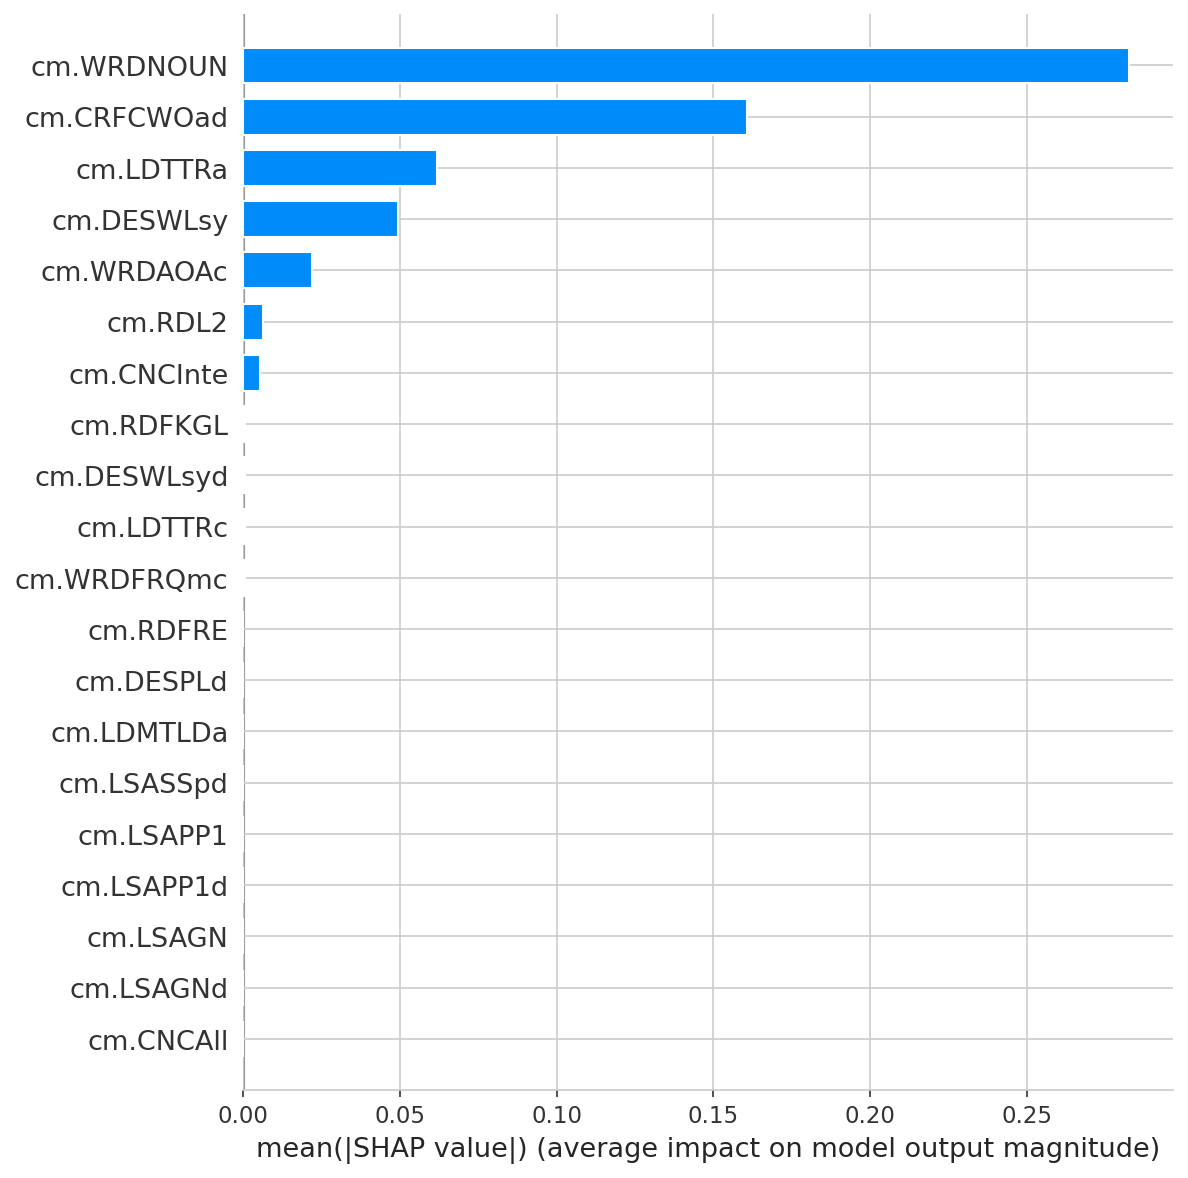

In [43]:
plt.figure(figsize = (15,8))
ax = shap.summary_plot(shap_values, 
                       datasetCurrent.columns,
                       plot_type='bar')
plt.show()

In [ ]:
type(shap_values)

shap._explanation.Explanation

In [ ]:
clustering = shap.utils.hclust(X_train, y_train)

[14:26:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).


[14:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

No/low signal found from feature 4 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).


[14:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 10%|▉         | 9/94 [00:00<?, ?it/s]

[14:26:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 12%|█▏        | 11/94 [00:11<00:48,  1.69it/s]

[14:26:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 13%|█▎        | 12/94 [00:12<01:13,  1.12it/s]

[14:26:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 14%|█▍        | 13/94 [00:14<01:38,  1.22s/it]

[14:26:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 15%|█▍        | 14/94 [00:16<01:52,  1.41s/it]

[14:26:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 16%|█▌        | 15/94 [00:17<01:47,  1.36s/it]

[14:26:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 17%|█▋        | 16/94 [00:18<01:45,  1.35s/it]

[14:26:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 18%|█▊        | 17/94 [00:20<01:43,  1.35s/it]

[14:26:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 19%|█▉        | 18/94 [00:21<01:39,  1.30s/it]

[14:26:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 20%|██        | 19/94 [00:22<01:40,  1.34s/it]

[14:26:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 21%|██▏       | 20/94 [00:24<01:43,  1.40s/it]

[14:26:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 22%|██▏       | 21/94 [00:25<01:42,  1.41s/it]

[14:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 23%|██▎       | 22/94 [00:27<01:47,  1.49s/it]

[14:26:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 24%|██▍       | 23/94 [00:30<02:13,  1.88s/it]

[14:26:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 26%|██▌       | 24/94 [00:33<02:47,  2.39s/it]

[14:26:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 27%|██▋       | 25/94 [00:36<02:49,  2.45s/it]

[14:26:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 28%|██▊       | 26/94 [00:38<02:40,  2.36s/it]


[14:26:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:26:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of r

 29%|██▊       | 27/94 [00:42<03:00,  2.70s/it]

[14:27:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 30%|██▉       | 28/94 [00:44<02:47,  2.54s/it]

[14:27:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

No/low signal found from feature 27 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 28 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).


[14:27:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 33%|███▎      | 31/94 [00:45<01:26,  1.38s/it]

[14:27:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 34%|███▍      | 32/94 [00:47<01:25,  1.37s/it]

[14:27:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 35%|███▌      | 33/94 [00:48<01:22,  1.35s/it]

[14:27:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 36%|███▌      | 34/94 [00:49<01:22,  1.38s/it]

[14:27:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 37%|███▋      | 35/94 [00:51<01:21,  1.39s/it]

[14:27:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 38%|███▊      | 36/94 [00:52<01:20,  1.39s/it]

[14:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 39%|███▉      | 37/94 [00:54<01:21,  1.44s/it]

[14:27:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 40%|████      | 38/94 [00:56<01:28,  1.58s/it]

[14:27:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 41%|████▏     | 39/94 [00:57<01:27,  1.59s/it]

[14:27:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 43%|████▎     | 40/94 [00:59<01:22,  1.52s/it]

[14:27:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 44%|████▎     | 41/94 [01:00<01:12,  1.37s/it]

[14:27:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 45%|████▍     | 42/94 [01:01<01:14,  1.43s/it]

[14:27:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 46%|████▌     | 43/94 [01:03<01:25,  1.68s/it]

[14:27:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 47%|████▋     | 44/94 [01:05<01:17,  1.55s/it]

[14:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 48%|████▊     | 45/94 [01:05<01:04,  1.33s/it]

[14:27:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 49%|████▉     | 46/94 [01:07<01:12,  1.51s/it]

[14:27:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 50%|█████     | 47/94 [01:10<01:22,  1.76s/it]

[14:27:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 51%|█████     | 48/94 [01:12<01:29,  1.95s/it]

[14:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 52%|█████▏    | 49/94 [01:14<01:24,  1.88s/it]


[14:27:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of r

 53%|█████▎    | 50/94 [01:16<01:25,  1.94s/it]


[14:27:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of r

 54%|█████▍    | 51/94 [01:19<01:33,  2.18s/it]

[14:27:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

No/low signal found from feature 50 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).


[14:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 56%|█████▋    | 53/94 [01:22<01:18,  1.92s/it]

[14:27:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 57%|█████▋    | 54/94 [01:24<01:18,  1.96s/it]

[14:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 59%|█████▊    | 55/94 [01:26<01:22,  2.10s/it]

[14:27:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 60%|█████▉    | 56/94 [01:29<01:22,  2.18s/it]

[14:27:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 61%|██████    | 57/94 [01:32<01:25,  2.31s/it]

[14:27:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 62%|██████▏   | 58/94 [01:34<01:22,  2.28s/it]

[14:27:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 63%|██████▎   | 59/94 [01:36<01:17,  2.22s/it]


[14:27:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of r

 64%|██████▍   | 60/94 [01:40<01:32,  2.73s/it]

[14:28:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 65%|██████▍   | 61/94 [01:42<01:23,  2.54s/it]

[14:28:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 66%|██████▌   | 62/94 [01:44<01:12,  2.28s/it]

[14:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 67%|██████▋   | 63/94 [01:46<01:08,  2.22s/it]

[14:28:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 68%|██████▊   | 64/94 [01:48<01:04,  2.17s/it]

[14:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 69%|██████▉   | 65/94 [01:51<01:11,  2.47s/it]

[14:28:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 70%|███████   | 66/94 [01:54<01:12,  2.57s/it]

[14:28:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 71%|███████▏  | 67/94 [01:55<01:02,  2.30s/it]

[14:28:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 72%|███████▏  | 68/94 [01:57<00:54,  2.09s/it]

[14:28:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 73%|███████▎  | 69/94 [01:58<00:46,  1.85s/it]

[14:28:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 74%|███████▍  | 70/94 [01:59<00:39,  1.66s/it]

[14:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 76%|███████▌  | 71/94 [02:01<00:35,  1.52s/it]

[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

No/low signal found from feature 70 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).


[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 78%|███████▊  | 73/94 [02:02<00:21,  1.04s/it]

[14:28:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 79%|███████▊  | 74/94 [02:03<00:23,  1.17s/it]

[14:28:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 80%|███████▉  | 75/94 [02:05<00:26,  1.37s/it]

[14:28:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 81%|████████  | 76/94 [02:07<00:25,  1.43s/it]

[14:28:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 82%|████████▏ | 77/94 [02:08<00:26,  1.55s/it]

[14:28:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 83%|████████▎ | 78/94 [02:10<00:26,  1.64s/it]

[14:28:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 84%|████████▍ | 79/94 [02:13<00:27,  1.82s/it]

[14:28:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

No/low signal found from feature 78 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 79 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 80 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).


[14:28:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 88%|████████▊ | 83/94 [02:15<00:10,  1.00it/s]

[14:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 89%|████████▉ | 84/94 [02:16<00:09,  1.00it/s]

[14:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 90%|█████████ | 85/94 [02:17<00:10,  1.14s/it]

[14:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 91%|█████████▏| 86/94 [02:20<00:11,  1.38s/it]

[14:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 93%|█████████▎| 87/94 [02:23<00:13,  1.91s/it]

[14:28:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 94%|█████████▎| 88/94 [02:30<00:19,  3.23s/it]

[14:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 95%|█████████▍| 89/94 [02:32<00:15,  3.00s/it]

[14:28:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 96%|█████████▌| 90/94 [02:34<00:10,  2.64s/it]

[14:28:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 97%|█████████▋| 91/94 [02:35<00:06,  2.21s/it]

[14:28:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 98%|█████████▊| 92/94 [02:36<00:03,  1.92s/it]

[14:28:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 99%|█████████▉| 93/94 [02:38<00:01,  1.73s/it]

[14:28:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:28:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

100%|██████████| 94/94 [02:39<00:00,  1.67s/it]

[14:29:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

95it [02:41,  1.87s/it]

[14:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:29:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

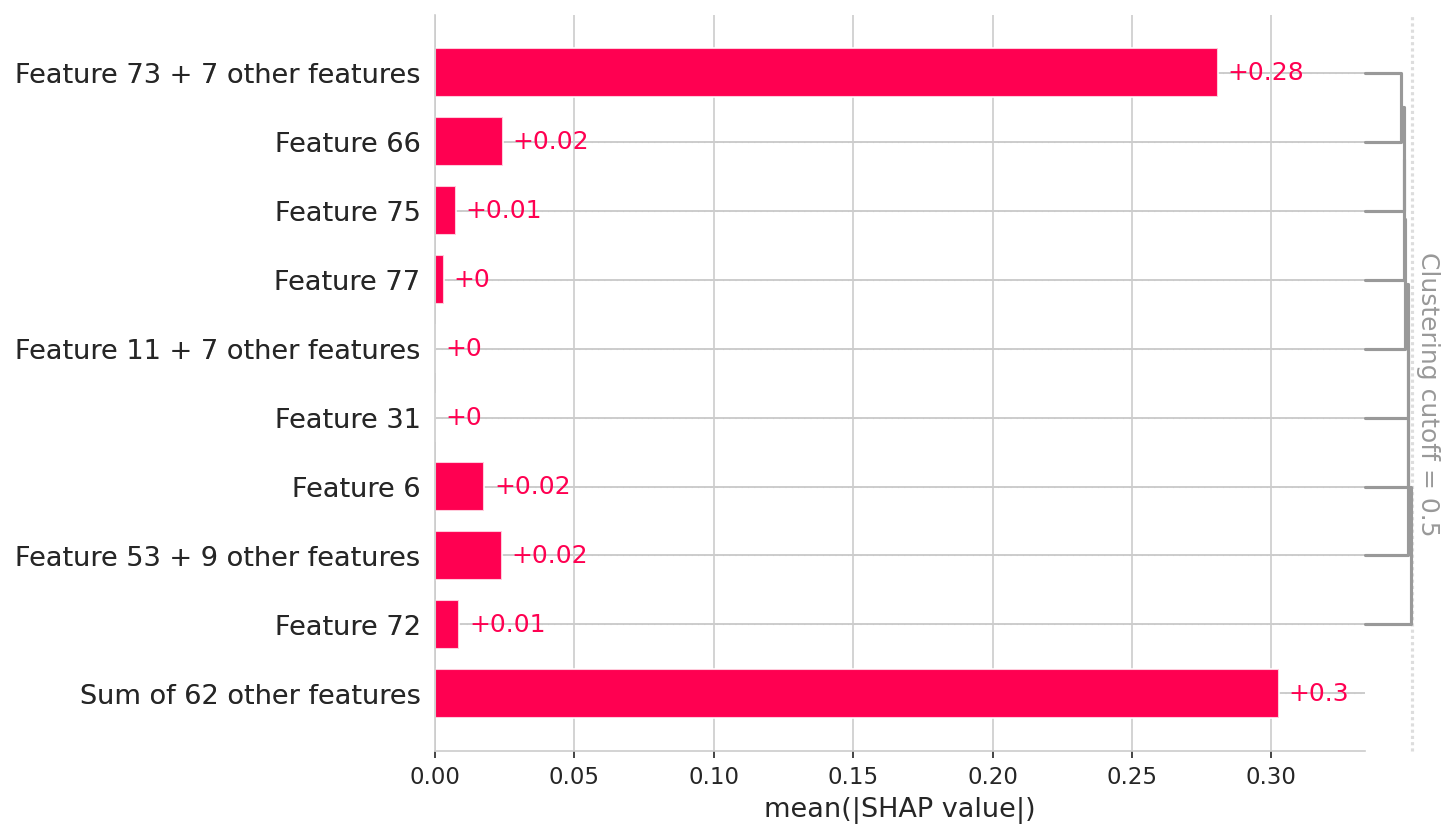

In [ ]:
shap.plots.bar(shap_values, clustering=clustering)

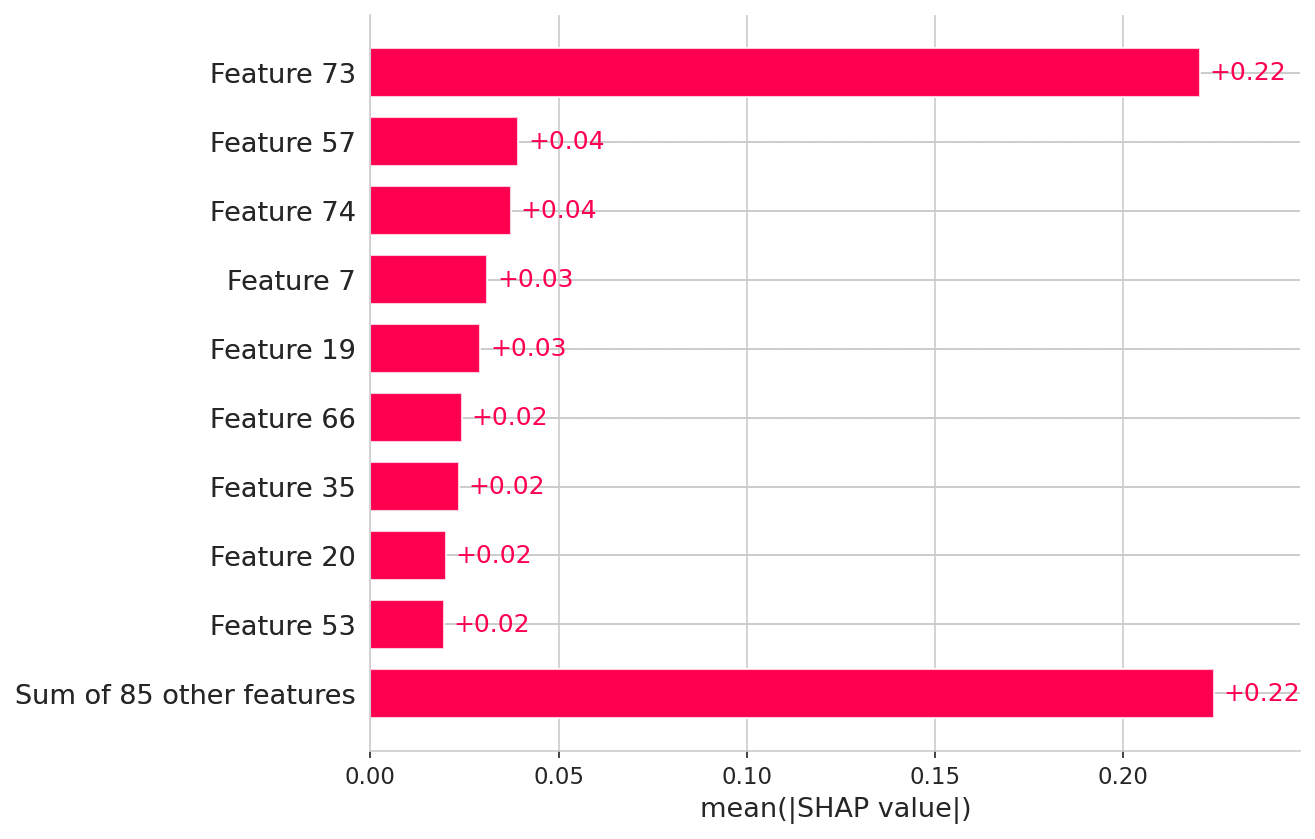

In [ ]:
shap.plots.bar(shap_values, max_display=10)

Cross Validation - Scikit-Learn's Random Forest Classifier

In [ ]:
#from sklearn.model_selection import cross_val_score
#rfc_cv = RandomForestClassifier(n_estimators=100)
#scores = cross_val_score(rfc_cv, X_train, y_train, cv=10, scoring = "accuracy")
#print("Scores:", scores)
#print("Mean:", scores.mean())
#print("Standard Deviation:", scores.std())

XGBoost

In [ ]:
#xgb_cv = XGBClassifier(n_estimators=100)
#scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
#print("Scores:", scores)
#print("Mean:", scores.mean())
#print("Standard Deviation:", scores.std())

The best parameters for prediction as found by the tuning tests are:

max_depth = 5
min_child_weight = 1
gamma = 0
subsample = 0.8
colsample_bytree = 0.8
reg_alpha = 0.005

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(datasetCurrent.drop('classe', axis=1), datasetCurrent['classe'],
                                                   test_size=0.33)

In [ ]:
xgboost = XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=100, gamma=0, 
                        min_child_weight=1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.005)

xgboost.fit(X_train, y_train)
preds = xgboost.predict(X_test)

accuracy = (preds == y_test).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy WITH optimal hyperparameters is: %3.2f" % (accuracy))

XGBoost's prediction accuracy WITH optimal hyperparameters is: 96.21


In [ ]:
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.93023256 0.97674419 0.90697674 0.88372093 0.90697674 0.95348837
 0.95348837 0.95238095 0.95238095 0.95238095]
Mean: 0.93687707641196
Standard Deviation: 0.02742289638853819


# XGBoost - Evaluation

In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 200, 1: 198}

In [ ]:
predictions = cross_val_predict(xgb, X_test, y_test, cv=5)
confusion_matrix(y_test, predictions)

array([[198,   2],
       [  8, 190]])

In [ ]:
print("Precision:", precision_score(y_test, predictions, average='micro'))
print("Recall:",recall_score(y_test, predictions, average='micro'))

Precision: 0.9748743718592965
Recall: 0.9748743718592965


In [ ]:
print("F1-Score:", f1_score(y_test, predictions, average='micro'))

F1-Score: 0.9748743718592965
